# ssp.train.py

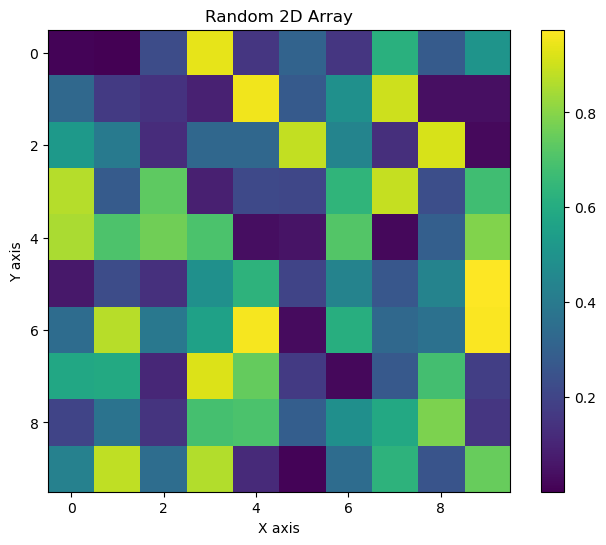

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen


# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = '4',
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 

    converted_net_forward = False,

    pretrained_net = None, 

    vth_mul_on = False,
    batch_norm_on = False,

    l2_norm_loss_weight = 0.0,

    QCFS_neuron_on = False,

    quantize_level_num = 0,

    fusion_net = False, # True False
    repeat_coding = False,
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'
    if converted_net_forward == True:
        assert SAE_net == False, 'converted_net_forward는 SAE_net이 False일 때만 가능'
    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    # tem=10
    # cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


    # vth_mul_on = True # True False
    # batch_norm_on = True # True False


    # 모델 초기화
    if SAE_net == False: # 여기서는 l2norm, lif bridge 둘 다 true면 l2norm먼저
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            if fusion_net == True:
                net = FUSION_net_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                    synapse_fc_trace_const1=1, 
                                    synapse_fc_trace_const2=v_decay, #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last, repeat_coding=repeat_coding).to(device)
            else: 
                net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                        batch_norm_on=batch_norm_on, QCFS_neuron_on=QCFS_neuron_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                    synapse_fc_trace_const1=1, 
                                    synapse_fc_trace_const2=v_decay, #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                print('converted_net', converted_net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[400, lateral_feature_num], decoder_ch=[400,n_sample], n_sample=n_sample, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
                                    batch_norm_on=batch_norm_on, QCFS_neuron_on=QCFS_neuron_on).to(device)
            net = torch.nn.DataParallel(net)
            if converted_net_forward:
                converted_net = SAE_converted_fc(encoder_ch=[400, lateral_feature_num], 
                                    decoder_ch=[400, n_sample], 
                                    in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                    synapse_fc_trace_const1=1,
                                    synapse_fc_trace_const2=v_decay,  #안씀 
                                    TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                    sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                    sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last,
                                    vth_mul_on=vth_mul_on, batch_norm_on=batch_norm_on).to(device) # lif bridge는 무조건 들어가게 해놨음.
                converted_net = torch.nn.DataParallel(converted_net)
                # print('converted_net', converted_net)
    else: # 여기서는 l2norm, lif bridge 둘 다 true면 lif또는 relu먼저
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last).to(device)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last).to(device)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_annbase_20250108_210641_941.pth'))
    if pretrained_net != None:
        ######################## 모델이 달라서 dict로 weight만 넣고싶을 때
        # # 저장된 가중치 로드
        saved_state_dict = torch.load(pretrained_net)
        current_state_dict = net.module.state_dict()

        # 함수 호출로 가중치 매핑
        updated_state_dict = map_and_load_weights(saved_state_dict, current_state_dict)

        # 업데이트된 state_dict를 네트워크에 로드
        net.module.load_state_dict(updated_state_dict)
        ######################## 모델이 달라서 dict로 weight만 넣고싶을 때

        ############## 일반적일 때
        # net.module.load_state_dict(torch.load(pretrained_net))
        ############## 일반적일 때
    
        # pre_net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge, activation_collector_on=False,
        #                         batch_norm_on=batch_norm_on, QCFS_neuron_on=False).to(device)
        # pre_net = torch.nn.DataParallel(net)
        # pre_net.module.load_state_dict(torch.load(pretrained_net))
        # copy_weights(pre_net.module.encoder , net.module.encoder )
        # copy_weights(pre_net.module.decoder , net.module.decoder  )

        




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
        
    k_means_acc_best = 0
    for epoch in range(max_epoch):
        print()
        l2_loss_bin= 0
        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        # if True or max_epoch != 1:
        if max_epoch != 1:
            for data in train_loader:
                optimizer.zero_grad()
                data = data.to(device)
                data = zero_to_one_normalize_features(data, level_num=quantize_level_num) if normalize_on else data
                spike_backup = data
                spike = data
                spike = spike.to(device) # batch, feature
                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                    spike = (spike > levels).to(torch.float) 

                    spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                    # spike: batch, time, level_num
                    # levels: time, level_num
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        if two_channel_input == True:
                            spike_backup = spike_backup.to(device)
                            spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_backup = (spike_backup <= levels).to(torch.float) 
                            spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                            spike_backup = spike_backup.unsqueeze(-2)
                            spike = torch.cat((spike, spike_backup), dim=-2)
                    assert spike.shape[0] == batch_size and spike.shape[1] == TIME
                elif 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                else:
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) #batch in_channel,feature
                    # if fusion_net == True:
                    #     spike = spikegen.rate(spike, num_steps=TIME).transpose(0, 1)

                # for i in range (3):
                #     plot_spike(spike[i,:,0,:].cpu().numpy())
                #     plot_spike(spike[i,:,1,:].cpu().numpy())
                # assert False
                        
                # spike_class = net(spike) # batch, time, feature
                encoded_spike = net.module.encoder(spike)
                spike_class = net.module.decoder(encoded_spike)

                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    loss = criterion(spike_class, spike)
                elif 'SAE' in net.module.__class__.__name__:
                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'
                else:
                    criterion = nn.MSELoss().to(device)
                    loss1 = criterion(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = criterion(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = criterion(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'

                    if l2_norm_loss_weight > 0:
                        assert len(encoded_spike.shape) == 2, 'time 성분 없는 걸로'
                        l2_loss = l2_norm_loss(encoded_spike, target_norm=1.0)  # L2Norm Loss 계산, l2 1.0되게.
                        loss = loss + l2_loss*l2_norm_loss_weight
                        l2_loss_bin += l2_loss.item()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
                iter += 1
        else:
            print('\n\n\n max_epoch 1이면 Train 안함!!!!!!!!!!!!!!!!!!!!!')
        if l2_norm_loss_weight > 0:
            print('l2_loss_bin', l2_loss_bin/len(train_loader))
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초, 전체 시작 시간 {current_time}")

        # plot_activation_distribution(net)

        if SAE_net == False and converted_net_forward == True:
            source_encoder = net.module.encoder 
            target_encoder = converted_net.module.encoder  
            copy_weights(source_encoder, target_encoder)

        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        k_means_acc = 0
        converted_k_means_acc = 0
        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            k_means_bin_origin_feature = []
            k_means_bin = []
            converted_k_means_bin = []
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                spike_template = torch.from_numpy(spike_template).to(device)
                spike = torch.from_numpy(spike).to(device)
                spike_template = zero_to_one_normalize_features(spike_template, level_num=quantize_level_num) if normalize_on else spike_template
                spike = zero_to_one_normalize_features(spike, level_num=quantize_level_num) if normalize_on else spike
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                


                net.eval()
                with torch.no_grad():
                    spike_torch = spike_template.float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                        if converted_net_forward == True:
                            spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                        # if fusion_net == True:
                        #     spike_torch = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                    ### forward #######################################################
                    inner_inf = net.module.encoder(spike_torch)
                    if SAE_net == False and converted_net_forward == True:
                        converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                    ### forward #######################################################

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                converted_spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = spike_batch
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                            if converted_net_forward == True:
                                spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                            # if fusion_net == True:
                            #     spike_torch = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                        ### forward #######################################################
                        inner_inf = net.module.encoder(spike_torch)
                        if SAE_net == False and converted_net_forward == True:
                            converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                        ### forward #######################################################
                            
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        if SAE_net == False and converted_net_forward == True:
                            converted_spike_hidden[now_index:now_end_index] = converted_inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16


                
                origin_kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= spike, true_labels=label-1, n_clusters=3, init_point=None)
                kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= torch.tensor(spike_hidden).to(device), true_labels=label-1, n_clusters=3, init_point=None)
                k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                k_means_bin.append(kmeans_accuracy)
                if SAE_net == False and converted_net_forward == True:
                    converted_kmeans_accuracy = cluster_spikes_with_accuracy_torch(features= torch.tensor(converted_spike_hidden).to(device), true_labels=label-1, n_clusters=3, init_point=None)
                    converted_k_means_bin.append(converted_kmeans_accuracy)
                # sklearn kmeans인데 cpu많이먹어서 버림.
                # origin_kmeans_accuracy = cluster_spikes_with_accuracy(features= spike.cpu().detach().numpy(), true_labels=label-1, n_clusters=3, init_point=None)
                # kmeans_accuracy = cluster_spikes_with_accuracy(features= spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                # k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                # k_means_bin.append(kmeans_accuracy)
                # if SAE_net == False and converted_net_forward == True:
                #     converted_kmeans_accuracy = cluster_spikes_with_accuracy(features= converted_spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                #     converted_k_means_bin.append(converted_kmeans_accuracy)





                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time() 
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])
            print(f'k_means origin feature average accuracy : {100*sum(k_means_bin_origin_feature)/(len(k_means_bin_origin_feature)+1e-12):.8f}%, total {k_means_bin_origin_feature}')
            
            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            if SAE_net == False and converted_net_forward == True:
                converted_k_means_acc = 100*sum(converted_k_means_bin)/len(converted_k_means_bin)
                print(f'converted_kmeans average accuracy : {converted_k_means_acc:.8f}%, total {converted_k_means_bin}')
            k_means_acc = 100*sum(k_means_bin)/len(k_means_bin)
            if k_means_acc > k_means_acc_best:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            
            k_means_acc_best = max(k_means_acc_best, k_means_acc)
            print(f'kmeans average accuracy best : {k_means_acc_best:.2f}%, kmeans average accuracy : {k_means_acc:.8f}%, total {k_means_bin}')
            print(f'cluster_accuracy_post_training_cycle_all_dataset : {cluster_accuracy_post_training_cycle_all_dataset}')

            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.8f}%")

            # kmeans accuracy기준으로 좋은 거 저장할 거임
            # if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
            #     # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
            #     torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
            #     print('save model')
            #     best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"k_means_acc": k_means_acc})
        wandb.log({"k_means_acc_best": k_means_acc_best})
        wandb.log({"converted_k_means_acc": converted_k_means_acc})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

# gpu = '5'
# Conv_net = True # True False
# SAE_net = False # True False

# # hyperparameter
# dataset_num = 16
# spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 2400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 7000
# learning_rate = 0.001
# normalize_on = True # True or False # 0부터1까지 normalize
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 10 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
# v_decay = 0.25 # -cor
# v_threshold = 0.25 # -cor
# v_reset = 10000.0 # -cor # 10000이상 일 시 hard reset
# BPTT_on = False # +cor # True False

# SAE_hidden_nomean = True # True False

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'SGD' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

# coarse_com_mode = False # True False
# coarse_com_config = (1.0, -0.0) # (max, min) (2.0, -2.0) (3.0, -3.0)

# sae_l2_norm_bridge = True # True False
# sae_lif_bridge = True # False True

# accuracy_check_epoch_term = 1

# lif_add_at_last = False # True False

# two_channel_input = False # True False

# lateral_feature_num = 4

# lc_adc_on = False # True False

# converted_net_forward = False # True False

# pretrained_net = None
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth'
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250113_134126_881_이거_94나오는거.pth'
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250115_200335_029_무한열차95.12.pth'
# # pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250115_200335_029_무한열차95.23.pth'

# vth_mul_on = False # True False
# batch_norm_on = False # True False

# l2_norm_loss_weight = 0 #0.0001 #0.1 #  0 # 0초과면 작동

# QCFS_neuron_on = False # True False

# quantize_level_num = 0 # 0이면 quantize 안함. 1이상이면 그 수만큼 quantize함.

# fusion_net = True # True False # SAE_net False, Conv_net True로 해라. TIME 적절하게 설정해주고.
# repeat_coding = True # True False # True면 repeat, False면 rate coding.

# wandb.init(project= f'spike_sorting just run',save_code=False)


# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
    
#     current_time = current_time,

#     optimizer = optimizer, #'Adam', 'SGD'

#     coarse_com_mode = coarse_com_mode,
#     coarse_com_config = coarse_com_config, # (max, min)

    
#     sae_l2_norm_bridge = sae_l2_norm_bridge,
#     sae_lif_bridge = sae_lif_bridge,

#     accuracy_check_epoch_term = accuracy_check_epoch_term,
    
#     lif_add_at_last = lif_add_at_last,

#     two_channel_input = two_channel_input,

#     lateral_feature_num = lateral_feature_num,

#     lc_adc_on = lc_adc_on, 

#     converted_net_forward = converted_net_forward,

#     pretrained_net = pretrained_net,

#     vth_mul_on = vth_mul_on,
#     batch_norm_on = batch_norm_on,

#     l2_norm_loss_weight = l2_norm_loss_weight,
    
#     QCFS_neuron_on = QCFS_neuron_on, # True False

#     quantize_level_num = quantize_level_num,

#     fusion_net = fusion_net, # True False
#     repeat_coding = repeat_coding,
#     )



In [4]:
# Sweep code


from unittest import TextTestRunner


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'grid', # 'random', 'bayes', 'grid'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'k_means_acc_best'},
    'parameters': 
    {
        # "gpu": {"values": ['1']},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [True]}, 
        "SAE_net": {"values": [False]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [2400]}, # [1400, 2400]

        "batch_size": {"values": [32]}, 
        "max_epoch": {"values": [10]}, 
        "learning_rate": {"values": [0.001, 0.0001]},
        "normalize_on": {"values": [True]},
        "need_bias": {"values": [False]}, # [True, False]

        "lif_add_at_first": {"values": [False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [4,8,10,20,50,100]}, #  [4,6,8,10]
        "v_decay": {"values": [0.25,0.50,0.75]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.125, 0.25, 0.50, 0.75, 0.875, 1.0]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True, False]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True]}, # [True, False]

        # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

        "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']

        "coarse_com_mode": {"values": [False]}, # [True, False]
        "coarse_com_config": {"values": [(1.0, -0.0)]}, # ['Adam', 'SGD']

        "sae_l2_norm_bridge": {"values": [True]}, # [True, False]
        "sae_lif_bridge": {"values": [True]}, # [False, True]
        
        "accuracy_check_epoch_term": {"values": [1]}, 

        "lif_add_at_last": {"values": [False]},# [True, False]

        "two_channel_input": {"values": [False]},# [True, False]

        "lateral_feature_num": {"values": [4]},# [True, False]

        "lc_adc_on": {"values": [False]},# [True, False]
        
        "converted_net_forward": {"values": [False]},# [True, False]

        "pretrained_net": {"values": [None]},# [None]
        # "pretrained_net": {"values": ['/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth']},# [None]

        "vth_mul_on": {"values": [False]},# [True, False]
        "batch_norm_on": {"values": [False]},# [True, False]

        "l2_norm_loss_weight": {"values": [0]},

        "QCFS_neuron_on": {"values": [False]},   # [True, False]

        "quantize_level_num": {"values": [0]}, 

        "fusion_net": {"values": [True]},   # [True, False]
        "repeat_coding": {"values": [True,False]},   # [True, False]

     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  '0'
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer

    coarse_com_mode = wandb.config.coarse_com_mode
    coarse_com_config = wandb.config.coarse_com_config # (max, min)

    sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
    sae_lif_bridge = wandb.config.sae_lif_bridge

    accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

    lif_add_at_last = wandb.config.lif_add_at_last

    two_channel_input = wandb.config.two_channel_input

    lateral_feature_num = wandb.config.lateral_feature_num

    lc_adc_on = wandb.config.lc_adc_on

    converted_net_forward = wandb.config.converted_net_forward

    pretrained_net = wandb.config.pretrained_net

    vth_mul_on = wandb.config.vth_mul_on
    batch_norm_on = wandb.config.batch_norm_on

    l2_norm_loss_weight = wandb.config.l2_norm_loss_weight

    QCFS_neuron_on = wandb.config.QCFS_neuron_on

    quantize_level_num = wandb.config.quantize_level_num

    fusion_net = wandb.config.fusion_net
    repeat_coding = wandb.config.repeat_coding
    

    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'

        coarse_com_mode = coarse_com_mode,
        coarse_com_config = coarse_com_config, # (max, min)
        
        sae_l2_norm_bridge = sae_l2_norm_bridge,
        sae_lif_bridge = sae_lif_bridge,

        accuracy_check_epoch_term = accuracy_check_epoch_term,

        lif_add_at_last = lif_add_at_last,
        
        two_channel_input = two_channel_input,
        
        lateral_feature_num = lateral_feature_num,

        lc_adc_on = lc_adc_on,

        converted_net_forward = converted_net_forward,

        pretrained_net = pretrained_net,

        vth_mul_on = vth_mul_on,
        batch_norm_on = batch_norm_on,

        l2_norm_loss_weight = l2_norm_loss_weight,

        QCFS_neuron_on = QCFS_neuron_on,

        quantize_level_num = quantize_level_num,

        fusion_net = fusion_net, 
        repeat_coding = repeat_coding,
        )
    
# sweep_id = 'ygoj9jt4'
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ozw9squb
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/spike_sorting%20cluster_train_system/sweeps/ozw9squb


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x5oqjyym with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_172851_576', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: vwoatqpa with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_173715_587', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: n0iuv6gz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_174424_551', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: wvrbl4am with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_180224_435', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 5fgkyjjj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_182202_557', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: s24ogish with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_184123_860', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yz659r5z with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_190106_715', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: yiwnzmig with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_191032_743', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 31c0efrp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_191844_040', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: gmrp4w0m with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_193813_693', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: s6zc7v0w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_195714_590', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 9n5gxyzq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_201618_926', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: sz0sg3lo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_203551_595', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: fgz45db7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_204341_696', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: nbsdcnqp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_205121_569', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: unp9ioks with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_211034_293', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ocarl9i7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_213016_267', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


k_means origin feature average accuracy : 82.26764992%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9150568181818182, 0.801817648783348, 0.6622234826999432, 0.9488619568430388, 0.822215777262181, 0.5872695852534562, 0.5005858230814294, 0.9429250891795482, 0.8922588099364529, 0.6752906976744186, 0.6000572573718866]
kmeans average accuracy best : 34.22%, kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
cluster_accuracy_post_training_cycle_all_dataset : [0.33393178 0.35561497 0.30269266 0.34729981 0.35544554 0.35
 0.34124629 0.3365897  0.33265514 0.33587786 0.34235075 0.31360947
 0.33609959 0.33709981 0.335

wandb: Agent Starting Run: hf1257is with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_214908_648', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [5

wandb: Agent Starting Run: z7vi5qxc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_220826_491', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: yoxsh9s0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_221656_301', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: b3u836oj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_222441_817', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: swc90uc9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_224348_614', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: 38vt7yp0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_230301_870', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: yf1qgbtu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_232211_769', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: v9mlzcwb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_234151_629', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 4x1pefe6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_234946_025', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: t9gszd91 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250131_235654_908', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 71a57lz1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_001632_949', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: mgfewyld with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_003614_826', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: vlx50gjc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_005536_309', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: 4d0p8a7q with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_011430_374', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 5pnv2uwt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_012233_646', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hun4z8jo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_013044_224', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iy7261rh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_013811_491', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: w89ezc2b with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_015744_611', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: ng3pk65j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_021650_887', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 1m1m28hv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_023559_937', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: b3yzucj2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_024334_037', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 2v74lq8n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_025046_582', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: i7ubo2gs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_031008_908', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: skdq6rz1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_032822_707', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uy7r1k0v with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_034630_284', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: ix7dwkgq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_040436_785', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: a5mqipxt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_041140_044', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: pkpo6zee with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_041906_581', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: v9z2xobf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_043733_610', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 7pi5sems with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_045556_272', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: w6wriuqp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_051417_397', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: uz5hhwcs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_053250_263', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: vf4xddpv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_054025_866', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: ycsmqcza with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_054739_496', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: pyqbxsz2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_060715_109', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: txed9dol with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_062707_581', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: n2urh8n1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_064537_306', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: g0n5ossk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_070404_380', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: ksej6rr9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_071149_878', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: n8x53nxp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_071903_577', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: pc9kyeyy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_073749_043', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: wq3ff3sn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_075628_385', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: vnjbz29x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_081453_643', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: bd7zgsje with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_083318_222', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: n58a9l3u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_084043_928', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: wc00xjhm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_084738_555', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 8ts89i58 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_090558_674', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: xrxqb8ki with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_092408_381', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ku5wvy1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_094222_426', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nmylt9qk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_100046_034', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
  (module): FUSION_net_conv1(
    (encoder): Sequential(
      (0): SSBH_rate_coding()
      (1): SSBH_DimChanger_one_two()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for_one_two_coupling()
      (11): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (12): SSBH_DimChanger_for_one_two_decoupling()
      (13): LIF_layer()
      (14): SSBH_DimChanger_for_one_two_coupling()
      (15): SSBH_DimChanger_for_fc()
      (16): Linear(in_featur

wandb: Agent Starting Run: 4jz8aw0b with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_100803_724', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: dbum5glp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_101530_211', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: al622klk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_102226_901', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 5f2qy1gc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_104117_407', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: xt83ronq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_110015_055', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: d0ufx2su with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_111847_686', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: ucn67y8n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_112716_477', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 155witgo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_113500_864', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: uq2xqup8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_115321_489', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xf6spmj7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_121145_375', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 8ixvds5h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_122934_877', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [5

wandb: Agent Starting Run: pugcfkk2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_124748_535', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4xsfzt4u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_125651_343', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: cnezvks1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_130428_918', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0pfalt6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_132232_322', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: z6cyjhh8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_134029_414', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: vbf0pr1p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_135823_763', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: o364jiw8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_141625_200', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 1pkg6irh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_142446_280', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pvn5t1ca with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_143203_647', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: rwj6vq1p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_145018_485', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: sce5wmnz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_150823_334', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 4pumoy6a with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_152604_400', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [50

wandb: Agent Starting Run: t0zb934u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_154350_490', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bpak3bqv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_155216_421', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: sj046jvy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_155947_147', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: t69kgwrm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_161744_849', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 11phy65j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_163546_229', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: 6p1u985d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_165344_545', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: qimzht3l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_171141_503', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 77qnr08v with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_171953_429', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nac2d53t with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_172728_640', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: tx5vyfxu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_174459_109', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: waqufsjy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_180313_423', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nhq1axyw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_182103_150', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [5

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n6bcvwi0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	traini

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_183850_719', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 05w5c59j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_184630_350', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: l1jas035 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_185402_850', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: gfesh7fz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_191201_799', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: h23f6c05 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_193001_957', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: y05nc2an with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_194759_029', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: uys9c341 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_200557_294', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: ogxn77v8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_201326_078', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: wxks3y29 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_202146_837', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 4pi5yevq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_203929_712', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: vh1z280v with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_205713_803', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: p02uia5p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_211456_488', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xggxuop4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_213249_634', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: ig07y1zw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_214019_719', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: b76216qp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_214745_402', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: 31rjg6ew with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_220542_602', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: k3ue6iud with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_222345_269', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 6eog1t91 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_224147_231', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: tn856cik with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_225945_794', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: xj512sp0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_230802_265', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 45na1e2w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_231543_054', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: e2veek7y with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_233332_679', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 2oc2kyux with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250201_235114_274', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gew1uqkm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_000911_005', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [5

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v64ir1r4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_002708_592', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: d96lr6nm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_003432_997', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0us2ogxq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_004217_451', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 95el72pf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_010018_043', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: vk3x5zd0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_011826_719', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: gkly2a5x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_013635_520', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: m4cuppva with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_015441_715', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: d6pcmifq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_020319_771', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: olpuzyjy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_021048_175', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: yr7rku8o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_022125_590', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: urey0rpu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_023914_022', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: lxh630rn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_025704_923', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: 7n7t5snd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_031456_808', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: d74g5uk5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_032258_540', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 2m89k2br with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_033024_647', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: rfqeow21 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_034839_441', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: d7if22wn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_040644_423', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: iywt60hu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_042448_864', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: a6yod871 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_044254_408', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: plbo0d1n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_045014_733', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: jwu44n24 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_045722_754', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 5csuv87n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_051519_959', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dq97mpg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_053327_667', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aotxp3lz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_055125_993', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: p06c21gw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_060916_140', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cov82xv0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_061659_370', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: ixr6d4ud with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_062417_489', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 3k16qyev with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_064224_062', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: 4gxucbl6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_070030_104', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: ypit2ip2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_071839_503', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 14nuxe7g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_073651_228', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: sfyqc0g5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_074401_680', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 9t67weel with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_075107_106', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 6i7cf7yx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_080903_095', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: zga5mbr8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_082652_499', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c54ipyof with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_084451_875', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: om28x5o8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_090253_835', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b1stsyry with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_091038_134', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: u11v6vsv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_091745_636', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: 9z2c2n77 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_093549_622', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: gxqo9l2i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_095355_234', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: t1r1k7ld with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_101203_333', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: l5xvldum with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_103008_791', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 2x3gxyrl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_103732_890', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cel8elx9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_104431_628', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: k8s2qiqa with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_105128_865', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 3pclc5lg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_110919_748', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: enpmtnfl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_112702_257', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: 0l3ju5ng with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_114448_447', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: 3rhr6c5y with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_115206_372', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: j3w1hvhd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_115911_932', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: e14s3k0e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_121704_044', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: habb6e23 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_123500_706', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: 5ve4bomq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_125251_606', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 9fmxfykf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_131045_578', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: 65mdd60x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_131732_157', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z6vin2o9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	tra

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_132427_357', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 4aiontl3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_134257_494', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ef56617x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	tra

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_140059_236', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: zvfg5dpr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_141842_237', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 1qlm1r9i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_143633_153', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
con

wandb: Agent Starting Run: c2m7pz5g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_144328_655', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: iopo63au with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_145021_945', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: lfhv7i4m with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_150859_927', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: yjo1h8b8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_152700_194', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
con

wandb: Agent Starting Run: hxfd0fm2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_154456_585', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: qeqxh9st with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_160254_767', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: nllo9yn1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_161023_149', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: aollzcij with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_161655_055', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: d4i6pkud with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_163439_430', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 7n0x7w3h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_165217_632', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 14396g9i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_171002_932', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: z9tpy13u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_172732_645', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: kj0z5ixy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_173435_769', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: wob4ud25 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_174139_095', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 1eep9fnf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_180002_916', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: akzr0ecw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_181801_022', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: 8d2pzr2e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_183557_545', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: pcm882vw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_185352_719', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: lynwmqfc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_190126_415', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: bkg7tz24 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_190756_880', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 36b9hecs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_191444_807', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n69k6wlc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	tra

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_193232_880', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: zd6bxo6l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_195026_984', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 1tkgpvro with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_200807_337', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
con

wandb: Agent Starting Run: yynpfsjd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_201520_416', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: gogacc1g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_202201_290', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: pxdyoad0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_203951_520', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: et4o1o9h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_205749_117', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
con

wandb: Agent Starting Run: 3jj64oqt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_211548_314', 'optimizer': 'Adam', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 62sl3tgo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_213347_751', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 10650x50 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_214300_438', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 4st6ny19 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_215032_260', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: wo4f9vyo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_220804_189', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: ijk4iyra with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_222549_534', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: qpi0qq59 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_224343_332', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: vtxzhex8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_230134_225', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: x85clxwl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_231033_365', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 624umbok with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_231849_367', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: xk5cc16d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_233656_836', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6g1p7p76 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250202_235458_116', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: z6a3p6my with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_001250_429', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: o1i3da9b with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_003042_505', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rk5rp6wk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_004005_674', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3c2u948w with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	train

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_004747_857', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: f2ukl2dk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_010547_866', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: bxlyu9hd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_012349_925', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: bwkq9rkt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_014133_290', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [5

wandb: Agent Starting Run: ylu8z7ss with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_015946_539', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: axl8wzx4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_020817_815', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: ht6c31rx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_021557_020', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 5o0agfbi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_023357_112', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: u4p38ope with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_025157_919', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 4mpjvtqk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_030952_572', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: pxa2eenp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_032746_368', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: rertiiaz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_033715_950', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: 86tpueix with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_034449_059', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: 9d0ug9af with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_040240_066', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: tztv21lg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_042027_941', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: ahysx4js with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_043817_960', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: nr6mfo6h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_045608_760', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)



epoch-8 loss : 0.06100
ae train 실행 시간: 18.667초, 전체 시작 시간 20250203_045608_760

epoch-8 accuracy check
k_means origin feature average accuracy : 82.25851350%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.915340909090909, 0.801817648783348, 0.6625070901871809, 0.9488619568430388, 0.822215777262181, 0.5866935483870968, 0.5005858230814294, 0.9429250891795482, 0.8922588099364529, 0.6738372093023256, 0.6000572573718866]
save model
kmeans average accuracy best : 70.15%, kmeans average accuracy : 70.15445305%, total [0.9385315879339784, 0.919931856899489, 0.903364969801553, 0.8802533103051238, 0.7680351906158358, 0.728125, 0.6646144825564351, 0.5955757231990925, 0.6925805498078629, 0.6397911832946636, 0.589573732718894, 0.5972466315172817, 0.6224732461355529, 0.5918544194107452, 0.5662790697674419, 0.5264815344975665]
cluster_accuracy_post_training_cycle_all_dataset : [0.92190305 0.91265597 0.89693593 0.89385475 0.77623762 0.55
 0.

wandb: Agent Starting Run: akir7c8n with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_050442_802', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: q4qpkuiu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_051210_230', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: djjcxzsf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_053011_131', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: o4rbmmk7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_054813_830', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: vn6rf5ab with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: True
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_060619_298', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': True, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: gfaaj6ql with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_062418_135', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: stabdnof with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_063248_764', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: 7a5fw9fl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_064013_951', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: k849974m with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_065807_626', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: dea2w7xn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_071602_848', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: krk5r19g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_073354_043', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: 1lzjgivy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_075148_362', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: 7r34vh30 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_075951_713', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: hus4xmvz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_080656_118', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: s1emm3jv with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_082503_022', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [50, 24, 11, 5]
Total number of encoder parameters: 26592
DataParallel(
  (module): FUSION_net_conv1(
    (encoder): Sequential(
      (0): SSBH_rate_coding()
      (1): SSBH_DimChanger_one_two()
      (2): SSBH_DimChanger_for_one_two_coupling()
      (3): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (4): SSBH_DimChanger_for_one_two_decoupling()
      (5): LIF_layer()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_DimChanger_for_one_two_coupling()
      (11): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (12): SSBH_DimChanger_for_one_two_decoupling()
      (13): LIF_layer()
      (14): SSBH_DimChanger_for_one_two_coupling()
      (15): SSBH_DimChanger_for_fc()
      (16): Linear(in_featur

wandb: Agent Starting Run: 5ziq7rl4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_084308_330', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: ntngj585 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_090113_113', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: x1mcyzgo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_091919_896', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: r8rza02a with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_092839_955', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: hutexqm1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_093632_820', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length

wandb: Agent Starting Run: i4co9osp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_095423_086', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Agent Starting Run: it53zgu2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_101213_372', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: q9r4lr5v with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_103003_454', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length [

wandb: Agent Starting Run: a8dva6bf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_104753_873', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: aoyuxwav with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_105559_662', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: 3korfq0e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_110317_469', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv le

wandb: Agent Starting Run: nx87sk72 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_112124_725', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: sr7r92qn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_113926_634', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: ym1yhkel with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_115728_265', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: j68hqvg0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_121539_002', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: bxf5swli with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_122559_547', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Agent Starting Run: jfw9tox4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_123400_585', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv lengt

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2t96t5lm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_125157_933', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv leng

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb238tfo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	trai

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_130953_428', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

wandb: Agent Starting Run: 4mpsrea4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_132744_603', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv length 

wandb: Agent Starting Run: 3diap6gk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_134538_482', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: ofc0sekf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_135420_399', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: un1cr31l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_140143_871', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv l

wandb: Agent Starting Run: c5gneidm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_142007_361', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv 

wandb: Agent Starting Run: qfgj0jk9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_143828_606', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv

wandb: Agent Starting Run: 4nb2fr64 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	QCFS_neuron_on: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 4
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_norm_on: False
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [1, 0]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: False
wandb: 	dataset_num: 16
wandb: 	fusion_net: True
wandb: 	l2_norm_loss_weight: 0
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 10
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: None
wandb: 	quantize_level_num: 0
wandb: 	repeat_coding: False
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': '0', 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 10, 'learning_rate': 0.0001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 4, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250203_145725_414', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': False, 'pretrained_net': None, 'vth_mul_on': False, 'batch_norm_on': False, 'l2_norm_loss_weight': 0, 'QCFS_neuron_on': False, 'quantize_level_num': 0, 'fusion_net': True, 'repeat_coding': False, 'coarse_com_config': [1, 0]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
conv len

In [ ]:
wandb.finish() 

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import pickle
# import json

# # current_time = '20250102_225243_972'

# with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
#     data = pickle.load(f)


# # JSON으로 저장
# with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
#     loaded_hyperparameters = json.load(f)

# loss_history = data['loss_history']
# mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
# mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
# mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
# print(data)
# max_acc = 0
# for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
#     if i[1] > max_acc:
#         max_acc = i[1]

# # 설정 정보 제목 작성
# title = (
#     f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
#     f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
#     f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
#     f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
# )

# # 데이터 리스트와 라벨 설정 (Loss 제외)
# data_list = [
#     ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
# ]

# # 플롯 생성
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # 첫 번째 y축: Accuracy 관련 데이터
# for label, data in data_list:
#     epochs, values = zip(*data)  # epoch, value 분리
#     ax1.plot(epochs, values, label=label)

# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")
# ax1.legend(loc="center right")
# ax1.grid(True)

# # x축을 정수만 표시하도록 설정
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # 두 번째 y축: Loss History
# ax2 = ax1.twinx()
# epochs, values = zip(*loss_history)
# ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
# ax2.set_ylabel("Loss", color="red")
# ax2.tick_params(axis="y", labelcolor="red")
# ax2.legend(loc="center left")

# # 제목 추가
# plt.title(title, fontsize=10)
# plt.tight_layout()
# plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋
filename_for_plot = [
    "Easy1_noise05", "Easy1_noise10", "Easy1_noise15", "Easy1_noise20",
    "Easy2_noise05", "Easy2_noise10", "Easy2_noise15", "Easy2_noise20",
    "Difficult1_noise05", "Difficult1_noise10", "Difficult1_noise15", "Difficult1_noise20",
    "Difficult2_noise05", "Difficult2_noise10", "Difficult2_noise15", "Difficult2_noise20"
]

# Accuracy 데이터
ANN_conv_accracy_set= [0.97935368, 0.97682709, 0.97028784, 0.96461825, 0.97524752, 0.95803571
, 0.95746785, 0.92628774, 0.965412,  0.97805344, 0.94869403, 0.92110454
, 0.96784232, 0.97551789, 0.91538462, 0.84446478]
SNN_fc_accuracy_set = [0.97114475, 0.97643732, 0.84400578, 0.78977821, 0.96616915, 0.92830189
, 0.86176032, 0.31984948, 0.80635401, 0.88769531, 0.61003861, 0.60377358
, 0.9592668,  0.92870999, 0.78333333, 0.67271859]
SNN_conv_accuracy_set = [0.97445601, 0.97737983, 0.97063072, 0.95998071, 0.96268657, 0.90566038
, 0.82545997, 0.68391345, 0.96116994, 0.92138672, 0.80694981, 0.49602781
, 0.83604888, 0.70611057, 0.69313725, 0.5819398 ]

# 평균 계산
average_ANN_conv = np.mean(ANN_conv_accracy_set)
average_SNN_fc = np.mean(SNN_fc_accuracy_set)
average_SNN_conv = np.mean(SNN_conv_accuracy_set)

# 데이터 준비
accuracies = np.array([ANN_conv_accracy_set, SNN_fc_accuracy_set, SNN_conv_accuracy_set])
averages = np.array([average_ANN_conv, average_SNN_fc, average_SNN_conv])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델의 정확도 플롯
ax.plot(accuracies[0], label='ANN Conv', marker='o', linestyle='-', color='blue')
ax.plot(accuracies[1], label='SNN FC', marker='o', linestyle='-', color='green')
ax.plot(accuracies[2], label='SNN Conv', marker='o', linestyle='-', color='red')

# 평균값 플롯
ax.axhline(y=average_ANN_conv, color='blue', linestyle='--', label=f'Average ANN Conv: {average_ANN_conv:.3f}')
ax.axhline(y=average_SNN_fc, color='green', linestyle='--', label=f'Average SNN FC: {average_SNN_fc:.3f}')
ax.axhline(y=average_SNN_conv, color='red', linestyle='--', label=f'Average SNN Conv: {average_SNN_conv:.3f}')

# 레이블 추가
ax.set_xticks(np.arange(len(filename_for_plot)))
ax.set_xticklabels(filename_for_plot, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Models on Datasets')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import csv
import matplotlib.pyplot as plt
import os  # 파일 경로 처리를 위한 모듈

# CSV 파일 경로
# csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep0_vth_mul.csv" # vth_mul해서 sweep 돌린거
csv_file_path = "/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/ae_test_deprecated/250115/sweep1.csv"  #vth_mul안한거

# 결과를 저장할 리스트
tuple_list = []

# CSV 파일 읽기
with open(csv_file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            # v_threshold, TIME, v_reset, converted_k_means_acc 값을 가져와 튜플로 변환
            v_threshold = float(row["v_threshold"])
            time = int(row["TIME"])
            v_reset = int(row["v_reset"])
            converted_k_means_acc = float(row["converted_k_means_acc"]) if row["converted_k_means_acc"] else None

            # 튜플 형태로 추가 (값이 None일 경우 처리할 수도 있음)
            tuple_list.append((v_threshold, time, v_reset, converted_k_means_acc))
        except ValueError as e:
            print(f"Error processing row {row}: {e}")

# 데이터를 TIME 기준으로 정렬
tuple_list.sort(key=lambda x: x[1])  # TIME을 기준으로 오름차순 정렬

# reset 방식에 따라 데이터를 나누기
soft_reset = [t for t in tuple_list if t[2] == 0]
hard_reset = [t for t in tuple_list if t[2] == 10000]

# reset 방식과 v_threshold에 따라 색상 설정
def plot_data(data, label_prefix, marker):
    for v_threshold in [1.0]:  # v_threshold 기준으로 제한
        filtered_data = [(t[1], t[3]) for t in data if t[0] == v_threshold]
        if filtered_data:  # 해당 v_threshold 데이터가 있을 경우만 플롯
            times, accuracies = zip(*filtered_data)  # x축(TIME), y축(converted_k_means_acc)
            
            plt.plot(
                times,
                accuracies,
                marker,
                label=f"{label_prefix}, v_threshold={v_threshold}",
                linestyle="--",
            )
            # 각 점에 accuracy 표시
            for time, acc in filtered_data:
                if acc == None:
                    continue
                plt.text(time, acc, f"{acc:.2f}", fontsize=8, ha="right")

# 그래프 초기화
plt.figure(figsize=(10, 6))

# soft_reset (v_reset=0) 데이터 플롯
plot_data(soft_reset, "Soft Reset", "o")

# hard_reset (v_reset=10000) 데이터 플롯
plot_data(hard_reset, "Hard Reset", "x")

# baseline accuracy 가로선 추가
baseline_accuracy = 94.43
plt.axhline(y=baseline_accuracy, color="red", linestyle="-", label=f"Baseline Accuracy ({baseline_accuracy}%)")
# baseline 텍스트 추가
plt.text(
    2000,  # x축 위치 (그래프 오른쪽 끝)
    baseline_accuracy + 0.4,  # y축 위치 (baseline 위 약간)
    f"ANN Baseline ({baseline_accuracy}%)",
    color="red",
    fontsize=10,
    ha="center",
)

# CSV 파일 이름 가져오기
csv_file_name = os.path.basename(csv_file_path)

# 그래프 세부 설정
plt.title(f"Converted SNN K-Means Accuracy vs TIME STEP - {csv_file_name}")
plt.xlabel("TIME STEP")
plt.ylabel("Converted K-Means Accuracy [%]")
plt.legend(loc="lower right")  # 범례를 오른쪽 아래로 이동
plt.grid(True)

# 그래프 출력
plt.show()
